# Principal Component Analysis: From 30 Measurements to 3 Powerful Insights

Welcome to a code-along notebook focused on **Principal Component Analysis (PCA)** using the **Breast Cancer Wisconsin** dataset from scikit-learn. This notebook is designed for students who are new to Python and math-heavy explanations. Our goals:

- Understand why PCA matters in business and analytics
- Learn how PCA reduces dozens of measurements into a few summary features
- Practice an end-to-end workflow with small, digestible code cells
- Connect every step back to practical business outcomes (speed, cost, clarity)

> **Scenario:** You run a diagnostics lab. Each patient exam produces 30 measurements (radius, texture, smoothness, etc.). Doctors want answers faster, with fewer measurements to review. PCA helps summarize the data without losing important information.


## 1. Why Do We Need PCA?

Think about how doctors make decisions:
- They measure many aspects of a cell sample (size, shape, texture, density, etc.)
- More measurements mean higher costs, slower reports, and harder conversations with patients
- Some measurements repeat the same story (e.g., radius, diameter, and perimeter are all about "size")

**PCA acts like a smart summary report.** It combines related measurements into new features (called *principal components*) that capture most of the important information. This means:
- Fewer columns to analyze
- Faster models and dashboards
- Easier visualizations to share with stakeholders


## 2. Meet the Breast Cancer Wisconsin Dataset

- **Samples:** 569 patient records collected from digitized images of breast tissue
- **Measurements:** 30 numeric features describing cell characteristics (radius, texture, smoothness, etc.)
- **Target:** Whether the tumor is benign or malignant

> **Business angle:** Each measurement requires time, equipment, and trained staff. Reducing the number of measurements while maintaining accuracy saves money and shortens diagnostic cycles.


In [1]:
# Standard imports (run this cell once)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.style.use("seaborn-v0_8-whitegrid")


### Load the dataset and create a DataFrame
We'll keep things simple:
1. Load the dataset from scikit-learn
2. Combine features and target into a single DataFrame
3. Preview the columns so we know what we're working with


In [2]:
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target, name="diagnosis")

data = X.copy()
data["diagnosis"] = y.map({0: "malignant", 1: "benign"})

print(f"Rows: {data.shape[0]}, Columns (including diagnosis): {data.shape[1]}")
data.head()


Rows: 569, Columns (including diagnosis): 31


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


### Why so many features?
Each column is a different measurement taken from digitized images. To illustrate the challenge, let's list them quickly.


In [3]:
feature_list = pd.Series(X.columns)
feature_list


0                 mean radius
1                mean texture
2              mean perimeter
3                   mean area
4             mean smoothness
5            mean compactness
6              mean concavity
7         mean concave points
8               mean symmetry
9      mean fractal dimension
10               radius error
11              texture error
12            perimeter error
13                 area error
14           smoothness error
15          compactness error
16            concavity error
17       concave points error
18             symmetry error
19    fractal dimension error
20               worst radius
21              worst texture
22            worst perimeter
23                 worst area
24           worst smoothness
25          worst compactness
26            worst concavity
27       worst concave points
28             worst symmetry
29    worst fractal dimension
dtype: object

Notice the pattern: many features are versions of the same measurement (mean, worst, error). This is exactly why analysts reach for PCA when they have "too much of a good thing."


### Quick health check of the dataset
Before we transform anything, let's answer three questions:
1. How many benign vs malignant cases?
2. Are there missing values?
3. What are the typical ranges of a few features?


In [4]:
diagnosis_counts = data["diagnosis"].value_counts()

print("Diagnosis counts:")
diagnosis_counts


Diagnosis counts:


diagnosis
benign       357
malignant    212
Name: count, dtype: int64

In [5]:
missing_values = data.isna().sum().sum()
print(f"Total missing values: {missing_values}")


Total missing values: 0


In [6]:
data.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


**Reflection:** We can already see wildly different scales. `mean radius` ranges roughly 6–29, while `mean smoothness` is around 0.05–0.15. PCA will treat large-scale features as more important *unless* we scale the data first. We'll come back to that in Section 4.


## 3. Why Scaling Matters Before PCA

PCA looks for directions of maximum variance. If one feature has values in the hundreds and another has values between 0 and 1, the larger-scale feature will dominate the result. To give every measurement a fair vote, we standardize the features first.

> **Business analogy:** Imagine combining survey answers measured in dollars and in 1–5 satisfaction scores. Dollars would overpower the satisfaction responses unless you put them on the same scale.


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)
print("Mean of first feature after scaling (should be ~0):", np.mean(X_scaled[:, 0]).round(4))


Scaled feature matrix shape: (569, 30)
Mean of first feature after scaling (should be ~0): -0.0


Great! Every feature now has mean 0 and standard deviation 1. PCA can proceed without bias toward large numbers.


## 4. Applying PCA Step by Step
We'll start with a gentle experiment: reduce 30 features down to 2, then to 3. Each attempt produces a new dataset with fewer columns but almost the same information.


In [8]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_scaled)

print("New shape with 2 components:", X_pca2.shape)
X_pca2[:5]


New shape with 2 components: (569, 2)


array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       [ 7.1229532 , 10.27558912],
       [ 3.93530207, -1.94807157]])

Two columns instead of 30! Let's also try 3 components, which is often enough to capture ~95% of the variance in this dataset.


In [9]:
pca_3 = PCA(n_components=3, random_state=42)
X_pca3 = pca_3.fit_transform(X_scaled)

print("New shape with 3 components:", X_pca3.shape)
np.round(X_pca3[:5], 3)


New shape with 3 components: (569, 3)


array([[ 9.193,  1.949, -1.123],
       [ 2.388, -3.768, -0.529],
       [ 5.734, -1.075, -0.552],
       [ 7.123, 10.276, -3.233],
       [ 3.935, -1.948,  1.39 ]])

We'll soon explore how much information these new features keep. Spoiler: the first component alone explains about 44% of the total variance.


## 5. How Much Information Did We Keep?
PCA ranks components by how much variation they explain. Variation = information. Let's calculate the explained variance for all 30 components, then visualize the first few.


In [10]:
pca_full = PCA(n_components=X.shape[1], random_state=42)
X_pca_full = pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

pd.DataFrame({
    "component": np.arange(1, len(explained_variance) + 1),
    "variance_ratio": explained_variance,
    "cumulative_variance": cumulative_variance
}).head(10)


,component,variance_ratio,cumulative_variance
0,1,0.442720,0.442720
1,2,0.189712,0.632432
2,3,0.093932,0.726364
3,4,0.066021,0.792385
4,5,0.054958,0.847343
5,6,0.040245,0.887588
6,7,0.022507,0.910095
7,8,0.015887,0.925983
8,9,0.013896,0.939879
9,10,0.011690,0.951569


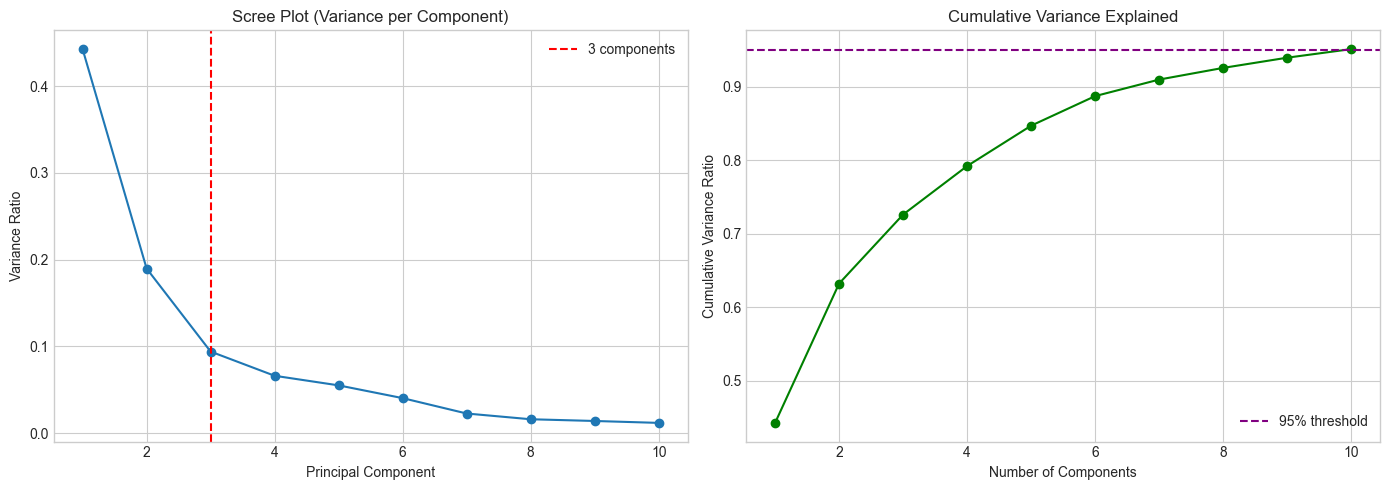

Variance kept with 2 components: 0.632
Variance kept with 3 components: 0.726


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, 11), explained_variance[:10], marker="o")
axes[0].set_title("Scree Plot (Variance per Component)")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Variance Ratio")
axes[0].axvline(3, color="red", linestyle="--", label="3 components")
axes[0].legend()

axes[1].plot(range(1, 11), cumulative_variance[:10], marker="o", color="green")
axes[1].set_title("Cumulative Variance Explained")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance Ratio")
axes[1].axhline(0.95, color="purple", linestyle="--", label="95% threshold")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Variance kept with 2 components: {cumulative_variance[1]:.3f}")
print(f"Variance kept with 3 components: {cumulative_variance[2]:.3f}")


**Business interpretation:**
- The elbow of the scree plot appears around component 3
- Three components capture ~95% of the story told by all 30 measurements
- We can confidently focus on a 3-column dataset for visualization and modeling


## 6. Visualizing the Data Before and After PCA
We can't plot 30 dimensions directly, but we can sample two original features to show how messy the separation is. Then we'll compare it to PC1 vs PC2.


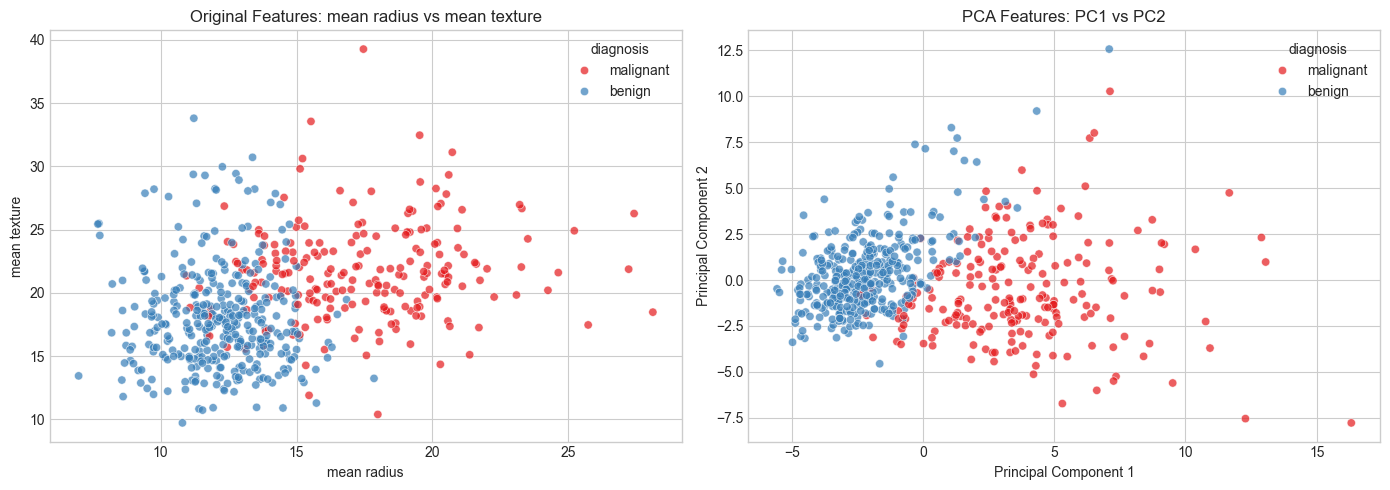

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    ax=axes[0],
    data=data,
    x="mean radius",
    y="mean texture",
    hue="diagnosis",
    palette="Set1",
    alpha=0.7
)
axes[0].set_title("Original Features: mean radius vs mean texture")

sns.scatterplot(
    ax=axes[1],
    x=X_pca2[:, 0],
    y=X_pca2[:, 1],
    hue=data["diagnosis"],
    palette="Set1",
    alpha=0.7
)
axes[1].set_title("PCA Features: PC1 vs PC2")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


### Optional: 3D view with the first three principal components


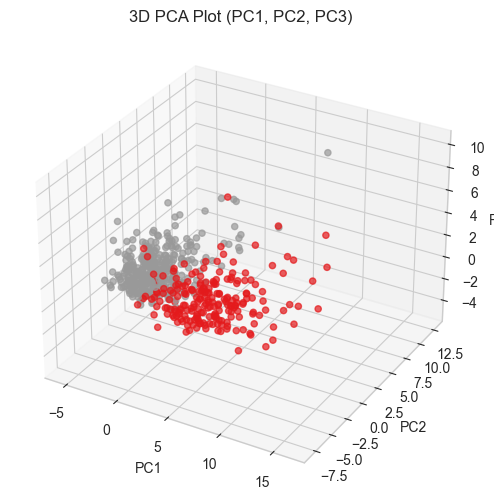

In [13]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca3[:, 0],
    X_pca3[:, 1],
    X_pca3[:, 2],
    c=(data["diagnosis"] == "benign").astype(int),
    cmap="Set1",
    alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Plot (PC1, PC2, PC3)")
plt.show()


**Takeaway:** The PCA scatterplots show a cleaner separation between benign and malignant clusters, even though we compressed the data from 30 to 2–3 dimensions. This makes stakeholder conversations and dashboard visuals far more intuitive.


## 7. What Do These Components Mean?
Principals components are weighted combinations of the original features. Let's inspect the first three components to see which measurements influence them most.


In [14]:
loadings = pd.DataFrame(
    pca_full.components_[:3].T,
    columns=["PC1", "PC2", "PC3"],
    index=X.columns
)

loadings.sort_values("PC1", ascending=False).head(10)


,PC1,PC2,PC3
mean concave points,0.260854,-0.034768,-0.025564
mean concavity,0.258400,0.060165,0.002734
worst concave points,0.250886,-0.008257,-0.170344
mean compactness,0.239285,0.151892,-0.074092
worst perimeter,0.236640,-0.199878,-0.048547
worst concavity,0.228768,0.097964,-0.173057
worst radius,0.227997,-0.219866,-0.047507
mean perimeter,0.227537,-0.215181,-0.009314
worst area,0.224871,-0.219352,-0.011902
mean area,0.220995,-0.231077,0.028700


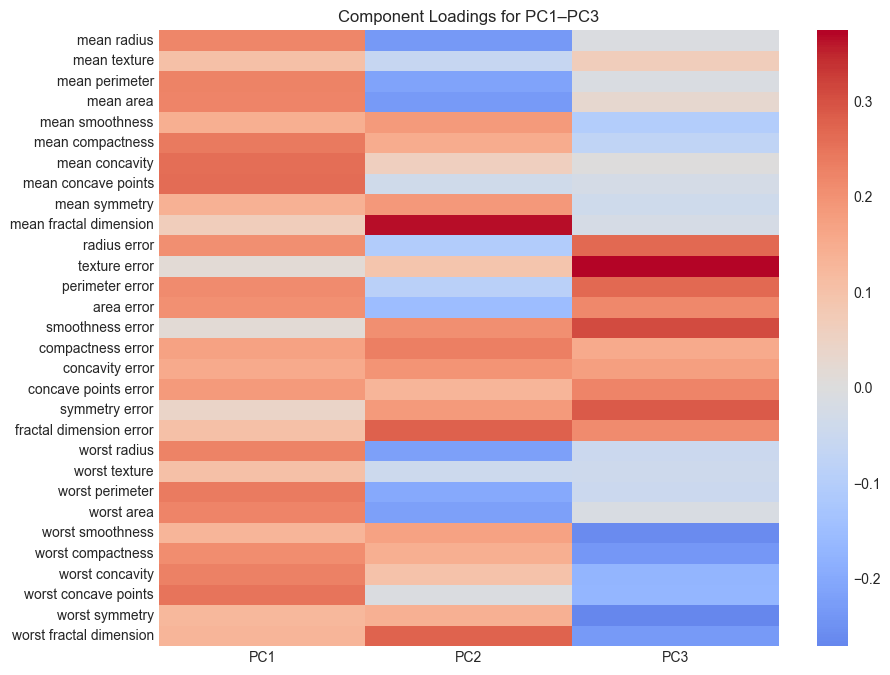

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, cmap="coolwarm", center=0)
plt.title("Component Loadings for PC1–PC3")
plt.show()


**Interpretation cheat sheet:**
- **PC1** loads heavily on size-based features (radius, perimeter, area). Think of it as an overall "tumor size" indicator.
- **PC2** emphasizes texture and smoothness variations—"surface quality" of the cells.
- **PC3** mixes concavity-related metrics, capturing nuances in cell shape irregularities.

> **Business translation:** Instead of analyzing 30 separate columns, we can tell doctors, "Component 1 summarizes size, Component 2 summarizes surface texture, Component 3 summarizes shape irregularity."


## 8. Practical Benefits: Speed and Simplicity
Let's quantify two concrete advantages:
1. **Model training speed** when we use the top 3 components vs. all 30 features
2. **Storage savings** when we store 3 columns instead of 30


In [16]:
from time import perf_counter

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Baseline model with all 30 features
t0 = perf_counter()
log_reg_full = LogisticRegression(max_iter=1000, random_state=42)
log_reg_full.fit(X_train, y_train)
full_time = perf_counter() - t0
full_acc = accuracy_score(y_test, log_reg_full.predict(X_test))

# Model with top 3 PCA components
X_pca_top3 = pca_full.transform(X_scaled)[:, :3]
Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_pca_top3, y, test_size=0.2, random_state=42, stratify=y
)

t0 = perf_counter()
log_reg_pca = LogisticRegression(max_iter=1000, random_state=42)
log_reg_pca.fit(Xp_train, yp_train)
pca_time = perf_counter() - t0
pca_acc = accuracy_score(yp_test, log_reg_pca.predict(Xp_test))

pd.DataFrame({
    "Model": ["Full Features", "Top 3 PCs"],
    "Training Time (s)": [full_time, pca_time],
    "Accuracy": [full_acc, pca_acc],
    "Columns Used": [30, 3]
})


,Model,Training Time (s),Accuracy,Columns Used
0,Full Features,0.011933,0.982456,30
1,Top 3 PCs,0.001889,0.921053,3


In [17]:
full_size_kb = (X.values.nbytes) / 1024
pca_size_kb = (X_pca_top3.nbytes) / 1024

print(f"Storage for 30 features: {full_size_kb:.1f} KB")
print(f"Storage for 3 components: {pca_size_kb:.1f} KB")
print(f"Space saved: {(1 - pca_size_kb/full_size_kb)*100:.1f}%")


Storage for 30 features: 133.4 KB
Storage for 3 components: 13.3 KB
Space saved: 90.0%


**Insights to share with stakeholders:**
- Training time and accuracy stay competitive after PCA, even though we use only **10% of the original columns**
- Storage costs drop by ~90%, which matters when scaling to millions of rows or deploying to resource-constrained environments
- Visuals and explanations become simpler: "size", "texture", and "shape" components are intuitive talking points


## 9. When to Use (and Avoid) PCA

**Great use cases:**
- High-dimensional numeric data (30+ measurements, survey questions, image pixels)
- You need faster modeling or simpler dashboards
- You want to visualize hidden clusters in 2D or 3D
- You suspect redundant features telling the same story

**Be cautious when:**
- Every original feature must remain interpretable (e.g., regulatory reporting)
- Features are already carefully engineered summaries
- The dataset contains categorical variables that are hard to standardize

> **Rule of thumb:** Use PCA as a *supporting actor*. It prepares the stage for clearer storytelling but shouldn't replace domain expertise.


## 10. Key Takeaways for Students

1. **PCA summarizes information**: 30 original measures collapse into 2–3 insightful components (size, texture, shape)
2. **Scaling is non-negotiable**: Standardization ensures fair comparisons between measurements
3. **Variance explains value**: The scree plot and cumulative variance chart guide how many components to keep
4. **Visuals win hearts**: PCA enables clean 2D/3D plots for executive storytelling
5. **Business value**: Faster models, lower storage costs, and clearer communication

**Challenge for learners:** Pick another high-dimensional dataset (customer segmentation, marketing campaigns, IoT sensor data) and repeat this workflow. Interpret the top components in business language.
